In [ ]:
import os
import pandas as pd
import numpy as np
import bisect
import pickle
import math
from PIL import Image
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, RocCurveDisplay

# For ResNet
try:
  import timm
except:
  print('timm does not exist')
  !pip install timm
  import timm

try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 1. Data Preprocessing & Feature Engineering
- Resize images to 64x64
- Convert to grayscale
- Normalize to range [0, 1]
- Generate HOG features

Note:
- HOG features:
    - TLDR: These features describes the image in terms of its edges direction and magnitude in a localised area of 8 x 8 pixels (see image below)
    - More detailed explanation here: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
- Labels: {0: tops, 1: bottoms, 2: bags, 3: shoes, 4: others}
- Creates: 
    - X_train, X_test
    - X_train_hog, X_test_hog
    - y_train, y_test

In [2]:
data_paths = [os.path.join("dataset","train"), os.path.join("dataset","test")]
categories = ["tops", "bottoms", "bags", "shoes", "others"]
r1, r2 = 64, 64

X_data_train = []
X_data_train_hog = []
y_data_train = []

X_data_test = []
X_data_test_hog = []
y_data_test = []

for data_path in data_paths:
    for i, category in enumerate(categories):
        cat_path = os.path.join(data_path, category)
        for filename in os.listdir(cat_path):
            img_path = os.path.join(cat_path, filename)

            try:
                img = Image.open(img_path)
            except Exception as e:
                print(f"Error processing image '{img_path}': {e}")
                continue

            # Resize images
            img = img.resize((r1, r2)) 

            # Convert to black and white
            img = img.convert("L")

            # Normalize pixel values (0 to 1)
            img = np.array(img) / 255.0

            ###############################
            #   Generating HOG features   #
            ###############################
            fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), visualize=False)

            if "train" in data_path:
                # Flatten image and add to X_data
                X_data_train.append(img.flatten())
                # Add corresponding label to y_data
                y_data_train.append(i)

                X_data_train_hog.append(fd)

            elif "test" in data_path:
                X_data_test.append(img.flatten())
                y_data_test.append(i)

                X_data_test_hog.append(fd)

# Convert lists to np arrays
X_train = np.array(X_data_train)
X_train_hog = np.array(X_data_train_hog)
y_train = np.array(y_data_train)

X_test = np.array(X_data_test)
X_test_hog = np.array(X_data_test_hog)
y_test = np.array(y_data_test)

### Optional: Saving the Dataframes

In [3]:
train_df = pd.DataFrame(data=X_train, columns=[f"pixel_{i}" for i in range(X_train.shape[1])])
train_df['label'] = y_train

test_df = pd.DataFrame(data=X_test, columns=[f"pixel_{i}" for i in range(X_test.shape[1])])
test_df['label'] = y_test

with open("preprocessed_data/train_df.pkl", "wb") as f:
    pickle.dump(train_df, f)

with open("preprocessed_data/test_df.pkl", "wb") as f:
    pickle.dump(test_df, f)

train_df_hog = pd.DataFrame(data=X_train_hog, columns=[f"hog_{i}" for i in range(X_train_hog.shape[1])])
train_df_hog['label'] = y_train

test_df_hog = pd.DataFrame(data=X_test_hog, columns=[f"hog_{i}" for i in range(X_test_hog.shape[1])])
test_df['label'] = y_test

with open("preprocessed_data/hog_train_df.pkl", "wb") as f:
    pickle.dump(train_df, f)

with open("preprocessed_data/hog_test_df.pkl", "wb") as f:
    pickle.dump(test_df, f)

# Model 1: ResNet

In [4]:
class customDataset(Dataset):
    def __init__(self, X, y, r, transform=None):
        self.X = X.reshape((-1,r,r,1))
        self.y = y.reshape(-1,1)
        self.transform = transform
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]

        if self.transform:
            X = self.transform(X)
        
        return X, y
    
    def __len__(self):
        return len(self.X)

In [5]:
# Split training data into train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.2)

# Define dataset objects
transform = transforms.Compose([transforms.ToTensor()])

r = int(math.sqrt(X_tr.shape[-1]))
ds_train = customDataset(X_tr, y_tr, r, transform=transform)
ds_val = customDataset(X_val, y_val, r, transform=transform)
ds_test = customDataset(X_test, y_test, r, transform=transform)

# Create Dataset Loaders
batch_size = 32
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [6]:
timm_model = timm.create_model(model_name="resnet50", pretrained=True, num_classes=5, in_chans=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [7]:
def train_step(model, dataloader, optimizer, loss_fn, accuracy_fn, device):
    
    train_loss, train_acc = 0, 0
    all_preds, all_targets, all_probs = [], [], []

    model.to(device)
    model.train()

    for i, (X, y) in enumerate(dataloader):

        # Push to device
        X, y = X.to(device), y.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Feedforward
        logits = model(X.float())
        # Compute loss
        loss = loss_fn(logits, y.long().squeeze())
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

        train_loss += loss.item()
        y_preds = logits.argmax(dim=1)
        train_acc += accuracy_fn(y_preds, y.long().squeeze()).item()
        probs = F.softmax(logits, dim=1)

        all_preds += [y_preds]
        all_targets += [y.long().squeeze()]
        all_probs += [probs]

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {100* train_acc:.2f}%")
    return train_loss, train_acc, all_preds, all_targets, all_probs

def test_step(model, dataloader, loss_fn, accuracy_fn, device):

    test_loss, test_acc = 0, 0
    all_preds, all_targets, all_probs = [], [], []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X.float())
            loss = loss_fn(logits, y.long().squeeze())

            test_loss += loss.item()
            y_preds = logits.argmax(dim=1)
            test_acc += accuracy_fn(y_preds, y.long().squeeze()).item()
            probs = F.softmax(logits, dim=1)

            all_preds += [y_preds]
            all_targets += [y.long().squeeze()]
            all_probs += [probs]

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {100* test_acc:.2f}%")

    return test_loss, test_acc, all_preds, all_targets, all_probs

In [8]:
epochs = 20
best_val_loss = float("inf")
early_stopping_counter = 0
early_stopping_threshold = 5

for epoch in range(epochs):
    print("-"*50 + f" Current epoch: {epoch + 1} " + "-"*50)
    train_loss, train_acc, train_preds, train_targets, train_probs = train_step(
        model=timm_model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    val_loss, val_acc, val_preds, val_targets, val_probs = test_step(
        model=timm_model,
        dataloader=val_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(timm_model.state_dict(), "models/resnet_best_model.pth")  # Save the best model
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_threshold:
            print("Early Stopping Triggered")
            break

-------------------------------------------------- Current epoch: 1 --------------------------------------------------
Train loss: 0.38610 | Train accuracy: 86.13%
Test loss: 0.10519 | Test accuracy: 96.78%
-------------------------------------------------- Current epoch: 2 --------------------------------------------------
Train loss: 0.08663 | Train accuracy: 97.34%
Test loss: 0.03887 | Test accuracy: 98.84%
-------------------------------------------------- Current epoch: 3 --------------------------------------------------
Train loss: 0.04066 | Train accuracy: 98.70%
Test loss: 0.04320 | Test accuracy: 98.69%
-------------------------------------------------- Current epoch: 4 --------------------------------------------------
Train loss: 0.03477 | Train accuracy: 98.94%
Test loss: 0.04724 | Test accuracy: 98.26%
-------------------------------------------------- Current epoch: 5 --------------------------------------------------
Train loss: 0.01859 | Train accuracy: 99.40%
Test los

# ResNet Evaluation
Test Results using Best ResNet Model

In [9]:
model_path = "models/resnet_best_model.pth"
timm_model = timm.create_model(model_name="resnet50", num_classes=5, in_chans=1)
timm_model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

test_loss, test_acc, test_preds, test_targets, test_probs = test_step(
        model=timm_model,
        dataloader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

Test loss: 0.12063 | Test accuracy: 97.84%


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     1.0000    1.0000    1.0000        60
           2     0.9444    0.9714    0.9577        35
           3     0.9677    1.0000    0.9836        60
           4     0.9630    0.8667    0.9123        30

    accuracy                         0.9796       245
   macro avg     0.9750    0.9676    0.9707       245
weighted avg     0.9796    0.9796    0.9792       245



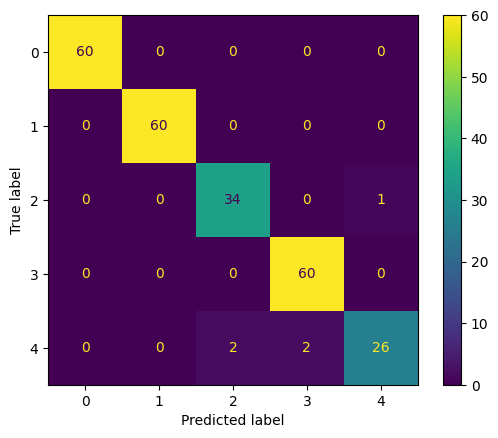

In [10]:
test_preds_list = [pred.item() for batch_preds in test_preds for pred in batch_preds]
test_targets_list = [target.item() for batch_targets in test_targets for target in batch_targets]
test_probs_list = []
for batch_probs in test_probs:
    for prob in batch_probs:
        test_probs_list.append(prob.tolist())

# 1. Classification Report
report = classification_report(test_targets_list, test_preds_list, digits=4)
print(report)

# 2. Confusion Matrix
resnet_cm = confusion_matrix(test_targets_list, test_preds_list)
ConfusionMatrixDisplay(confusion_matrix=resnet_cm).plot()

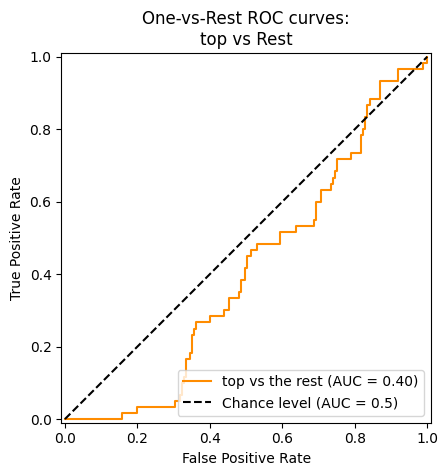

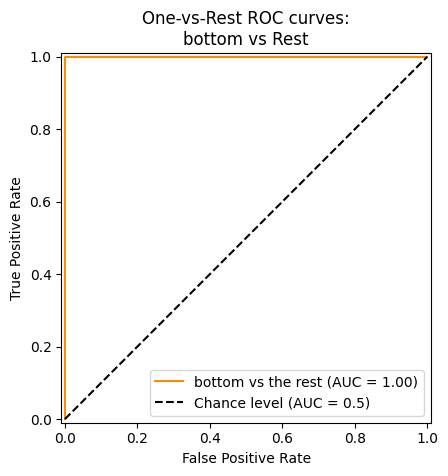

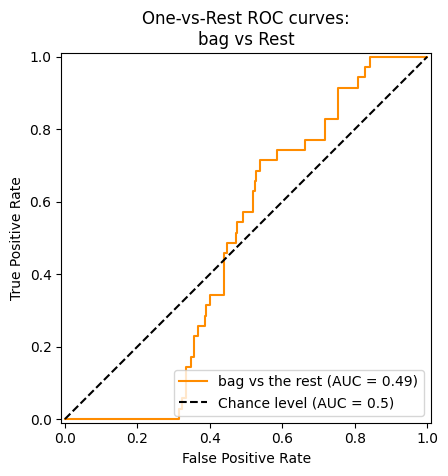

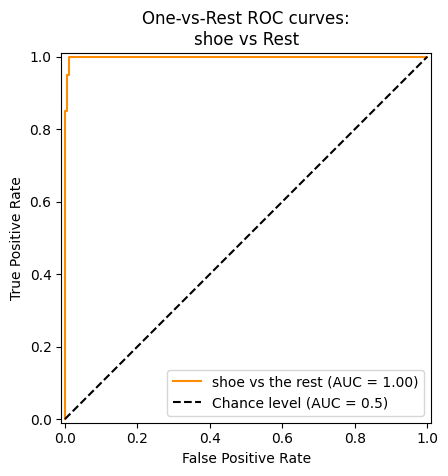

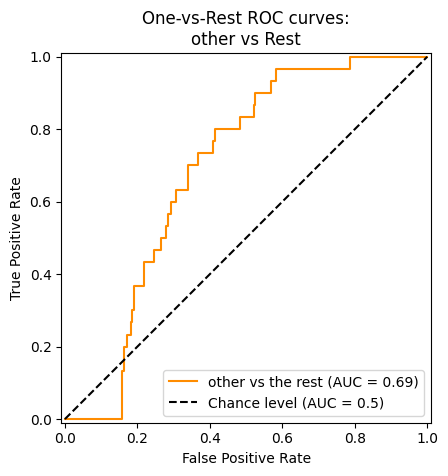

In [11]:
# 3. One vs Rest ROC curve

categories = ["top", "bottom", "bag", "shoe", "other"]
train_targets_list = [target.item() for batch_targets in train_targets for target in batch_targets]
y_train_str = [categories[label] for label in train_targets_list]
y_test_str = [categories[label] for label in test_targets_list]
y_score_arr = np.array(test_probs_list)

label_binarizer = LabelBinarizer().fit(y_train_str)
y_onehot_test = label_binarizer.transform(y_test_str)
y_onehot_test.shape  # (n_samples, n_classes)

for cat in categories:
    class_id = np.flatnonzero(label_binarizer.classes_ == cat)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score_arr[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",
    plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest",
    )